# Random forest classification tutorial

Classification Task: Predicting Soil Behavior (Binary Classification)

The task is a binary classification problem, where the goal is to predict whether a soil sample will exhibit contracting or dilative behavior based on the `state` parameter. If `state > 0`, soil tends to be contractive, and if `state < 0`, soil tends to be dilative. We first train the model using the training examples (i.e., feature-label). Then we test the model on unseen data to assess whether the model correctly classify the soil behavior (contractive or dilative)

## Data loading

Load the dataset and display its first few rows and information.



In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/yjchoi1/ml-tutorial-classification/main/state_prediction.csv"

try:
    df = pd.read_csv(url)
    display(df.head())
    display(df.info())
except FileNotFoundError:
    print("Error: 'state_prediction.csv' not found.")
    df = None

,M,N,Lambda_e,Gamma,H0,p,Irval,Chi,state,Qcpt
0,1.00,0.5,0.02,1.4,500,400,300,2,-0.10,64.492653
1,1.00,0.2,0.02,0.9,500,50,600,2,0.15,13.896755
2,1.50,0.2,0.07,1.2,500,100,100,4,0.05,29.735345
3,1.25,0.2,0.12,1.2,50,50,600,2,-0.15,52.391847
4,1.25,0.2,0.12,0.6,500,400,600,2,-0.15,96.268036


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   M         50000 non-null  float64
 1   N         50000 non-null  float64
 2   Lambda_e  50000 non-null  float64
 3   Gamma     50000 non-null  float64
 4   H0        50000 non-null  int64  
 5   p         50000 non-null  int64  
 6   Irval     50000 non-null  int64  
 7   Chi       50000 non-null  int64  
 8   state     50000 non-null  float64
 9   Qcpt      50000 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 3.8 MB


None

## Data exploration

Explore the dataset by visualizing relationships between features and the target variable 'state' using pair plots, correlation matrix, heatmap, and distributions of features.



Shape of the DataFrame: (50000, 10)


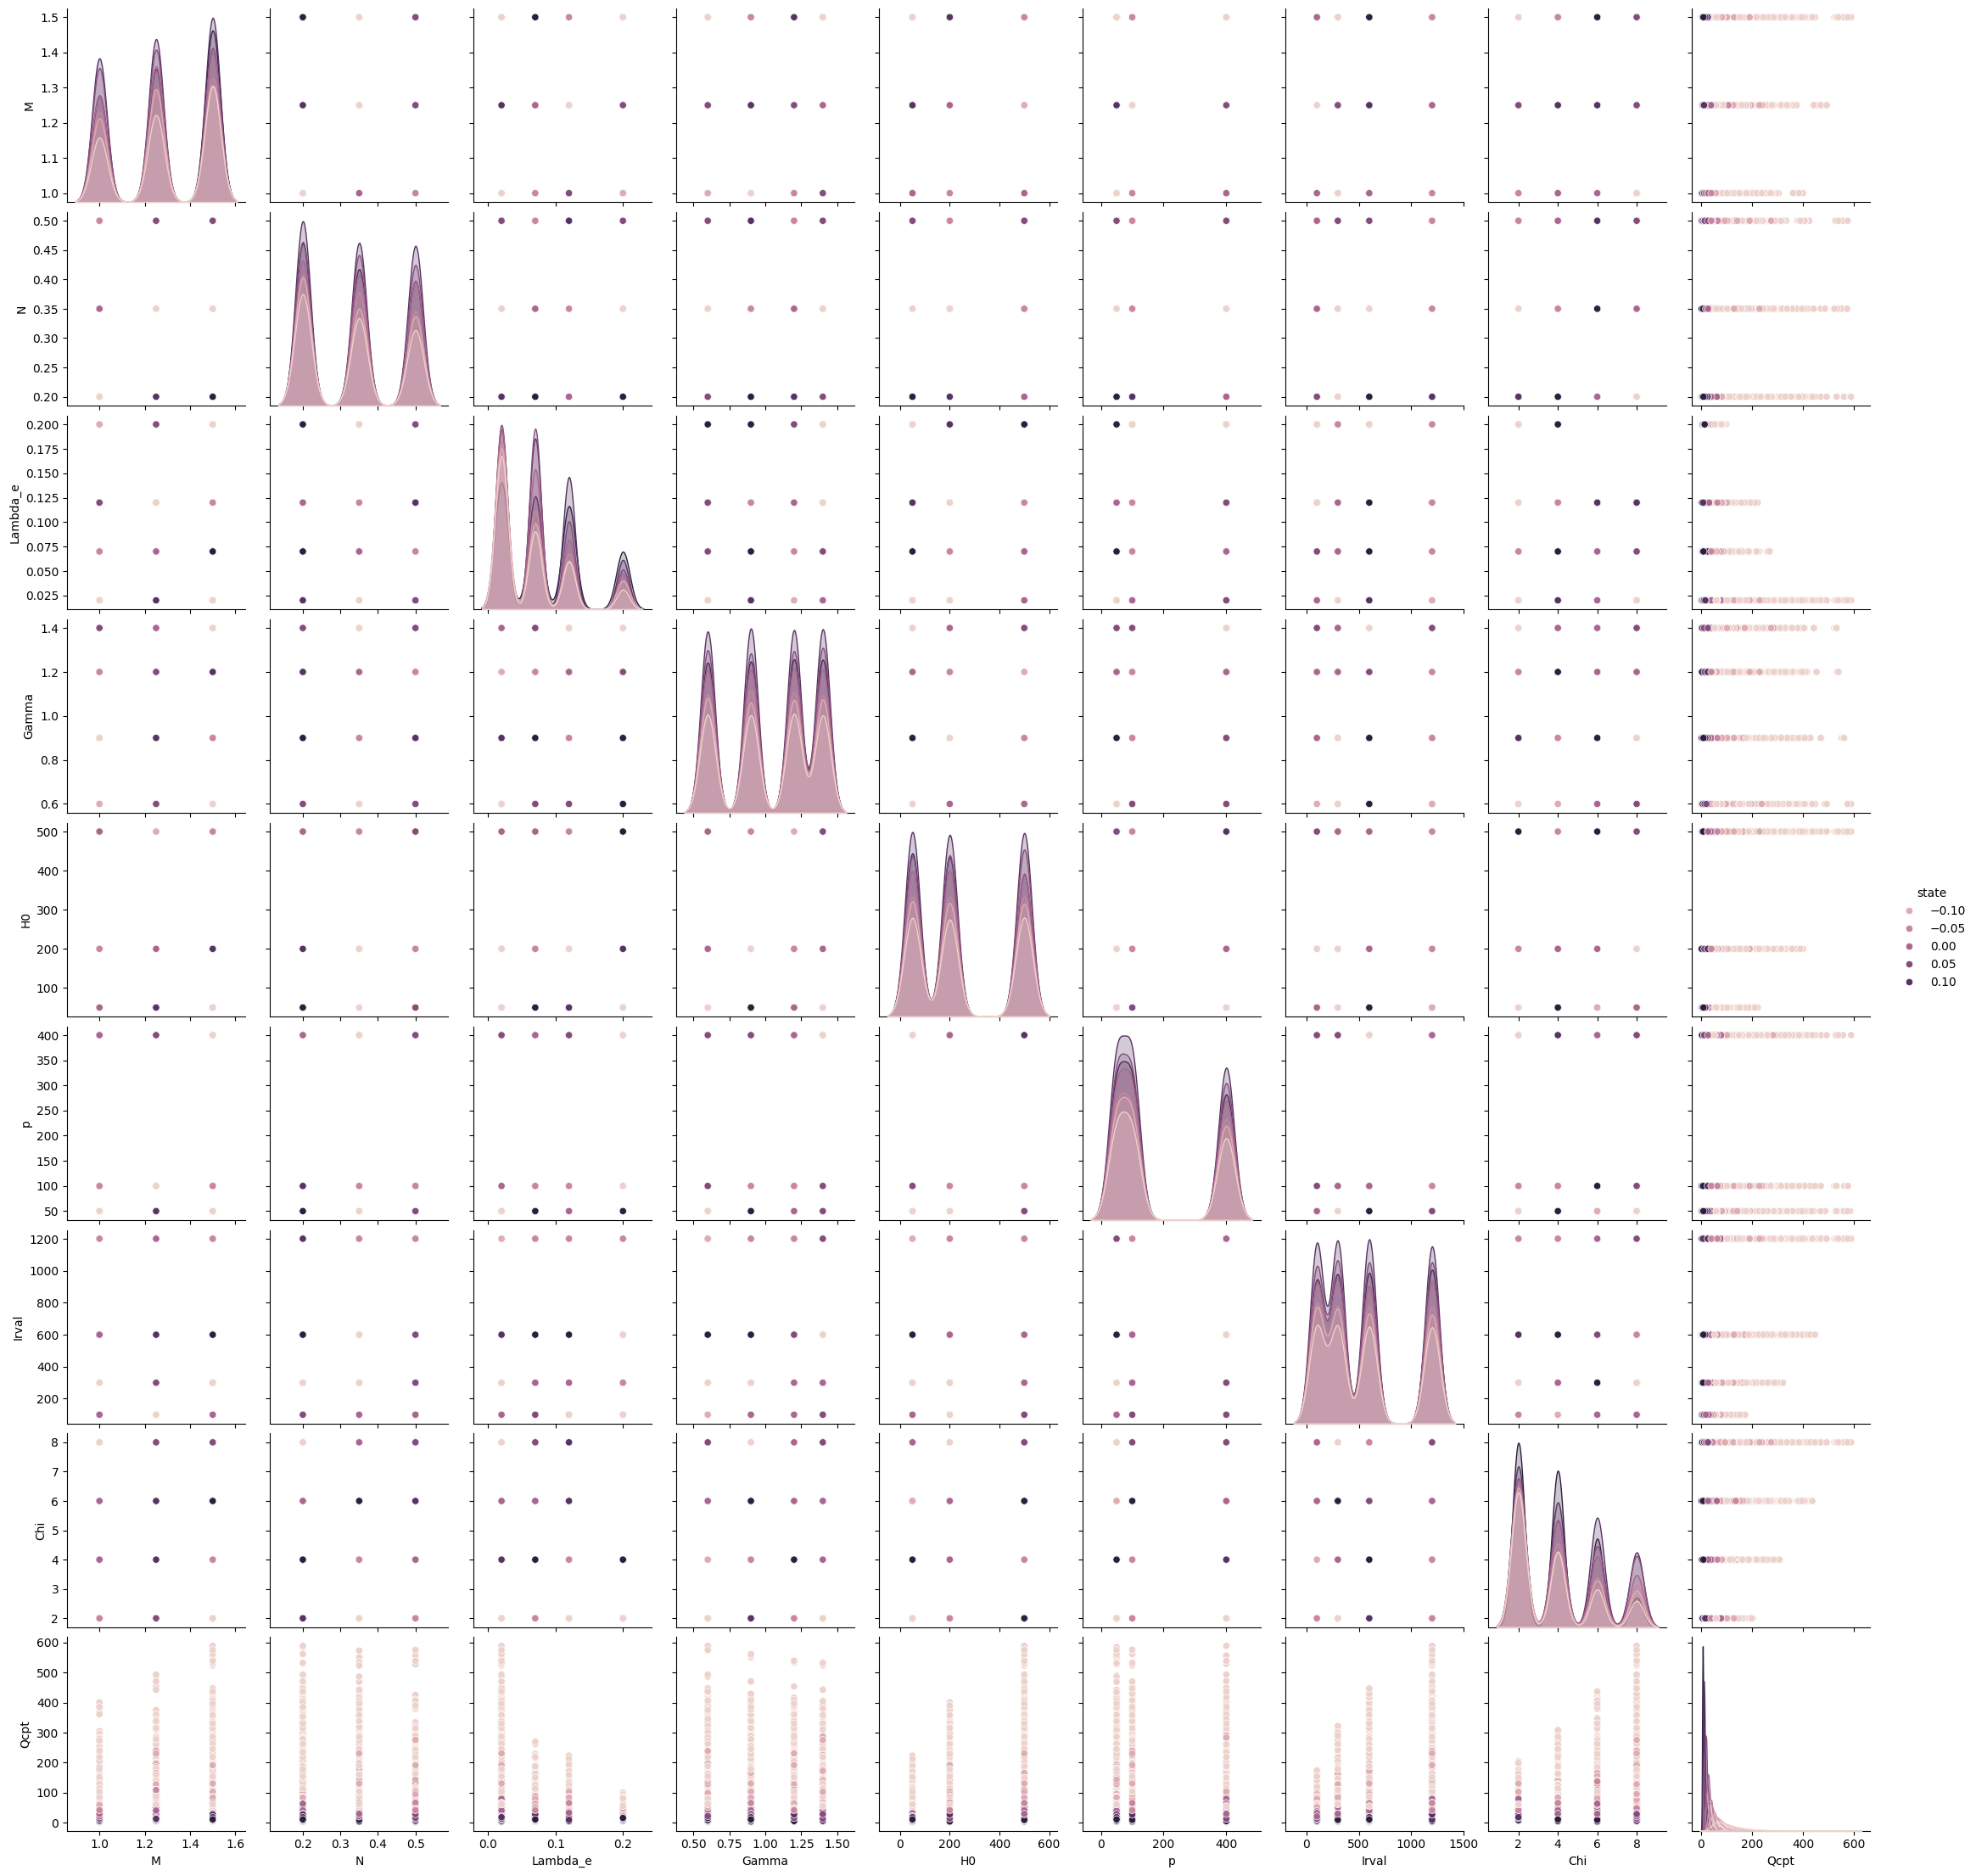

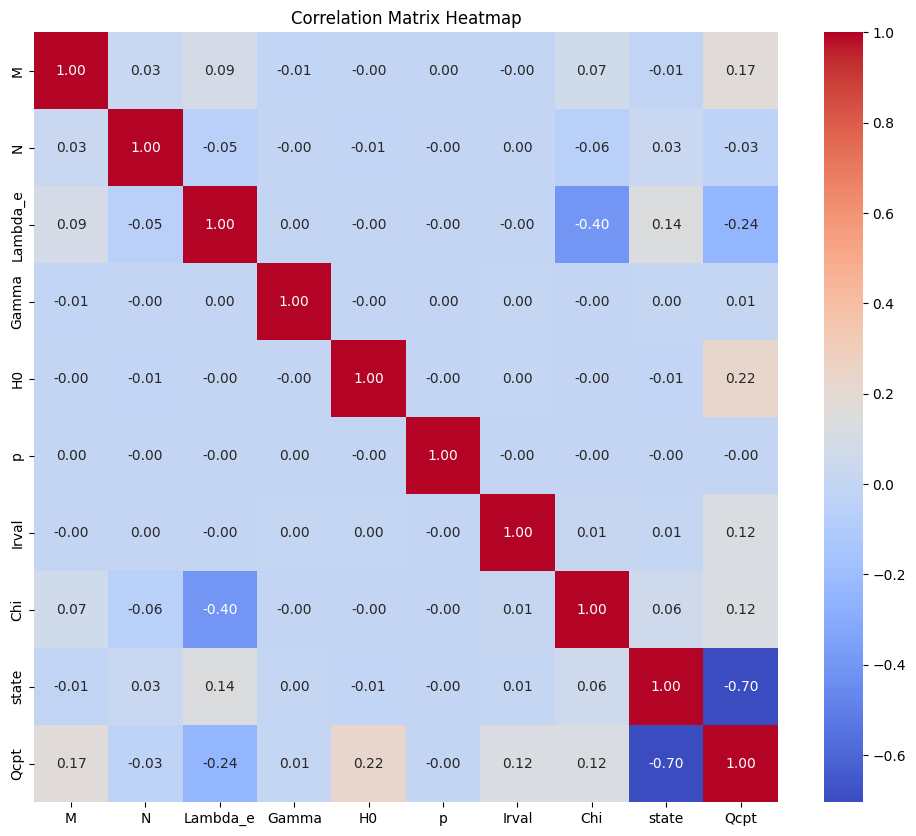

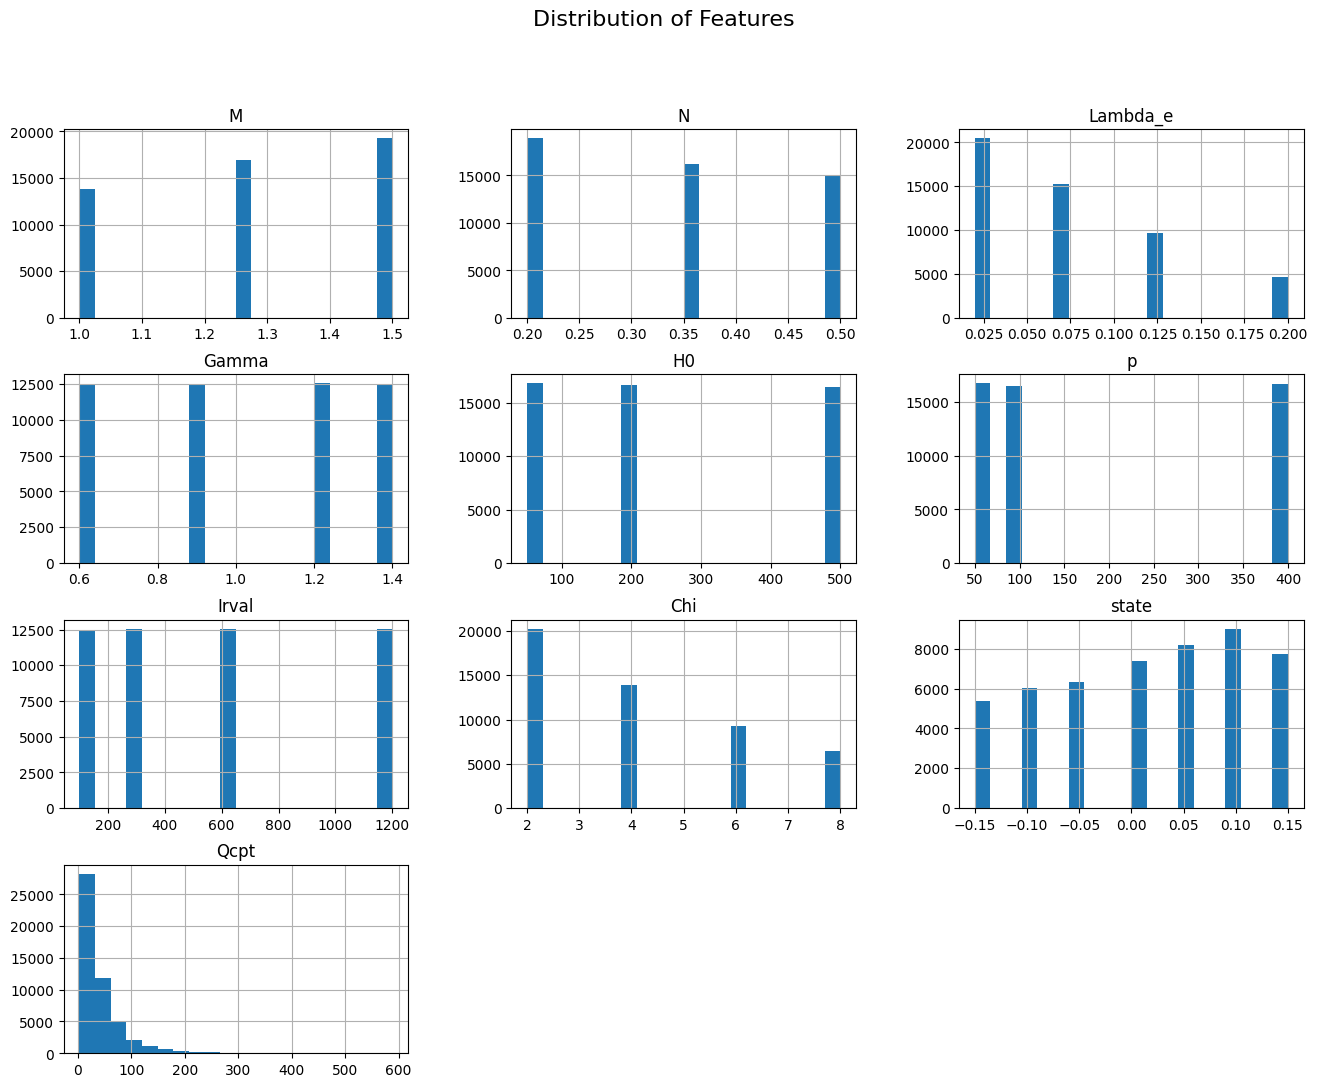

Correlation with 'state':
state       1.000000
Lambda_e    0.138958
Chi         0.061314
N           0.026727
Irval       0.007515
Gamma       0.003318
p          -0.001728
H0         -0.010818
M          -0.013867
Qcpt       -0.704059
Name: state, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Determine the shape of the DataFrame
print(f"Shape of the DataFrame: {df.shape}")

# Generate a pair plot
df_sample = df.sample(n=1000, random_state=42)
sns.pairplot(df_sample, hue='state', diag_kind='hist')
plt.show()

# Calculate and display the correlation matrix as a heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# Describe the distributions of each feature
df.hist(figsize=(16, 12), bins=20)
plt.suptitle("Distribution of Features", fontsize=16)
plt.show()

# Analyze the correlation between features and the target variable 'state'
print("Correlation with 'state':")
print(correlation_matrix['state'].sort_values(ascending=False))

## Data preparation


Remove the "gray zone" data points where 'state' is 0 and create a new binary target variable 'binary_state' based on the provided conditions. Then, drop the original 'state' column and verify the changes.



In [4]:
# Remove rows where 'state' is 0
df = df[df['state'] != 0]

# Create the 'binary_state' column using .loc for correct assignment
df['binary_state'] = 0
df.loc[df['state'] >= 0.05, 'binary_state'] = 1

# Drop the original 'state' column
df = df.drop('state', axis=1)

# Verify the changes
display(df.head())
display(df['binary_state'].value_counts())

<ipython-input-4-77b39fd1ae75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binary_state'] = 0


,M,N,Lambda_e,Gamma,H0,p,Irval,Chi,Qcpt,binary_state
0,1.00,0.5,0.02,1.4,500,400,300,2,64.492653,0
1,1.00,0.2,0.02,0.9,500,50,600,2,13.896755,1
2,1.50,0.2,0.07,1.2,500,100,100,4,29.735345,1
3,1.25,0.2,0.12,1.2,50,50,600,2,52.391847,0
4,1.25,0.2,0.12,0.6,500,400,600,2,96.268036,0


,count
binary_state,
1,24910
0,17718


## Data splitting

Split the data into training, validation, and testing sets using train_test_split.



In [5]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df.drop('binary_state', axis=1)
y = df['binary_state']

# First split: combined training/validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Second split: training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.15 / (0.15 + 0.7),  # Adjust test_size for the desired 70/15/15 split
    stratify=y_train_val,
    random_state=42,
)

## Model training

Train a random forest model using the training data.



In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)  # Set random_state for reproducibility

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Model optimization

Optimize the random forest model using GridSearchCV with k-fold cross-validation.


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 30],
    'max_depth': [3, 7],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best estimator
best_rf_model = grid_search.best_estimator_

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 30}


## Model evaluation


Evaluate the best model on the test set, generate a classification report, confusion matrix, ROC curve, and AUC.



              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2658
           1       1.00      0.99      1.00      3737

    accuracy                           0.99      6395
   macro avg       0.99      1.00      0.99      6395
weighted avg       0.99      0.99      0.99      6395



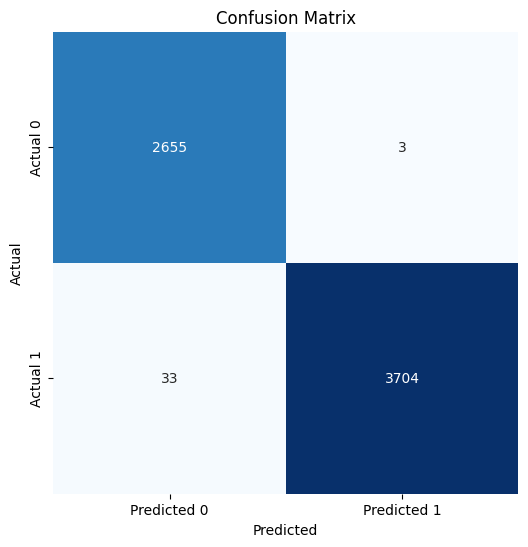

AUC: 0.9999786568858826


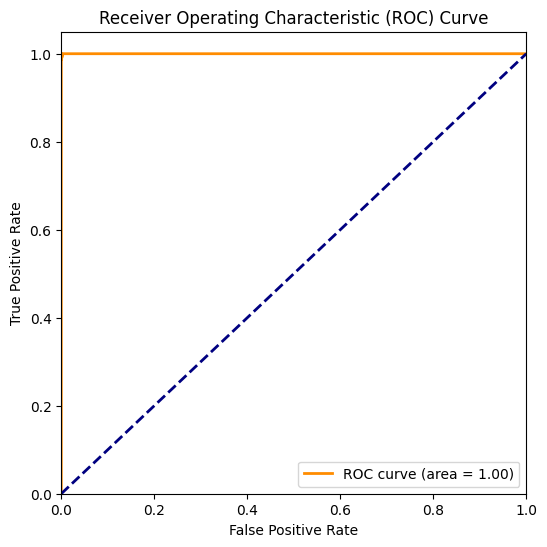

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
y_pred = best_rf_model.predict(X_test)

# Generate the classification report
print(classification_report(y_test, y_pred))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate the ROC curve and AUC
y_prob = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Print the AUC value
print(f"AUC: {roc_auc}")

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Model interpretation

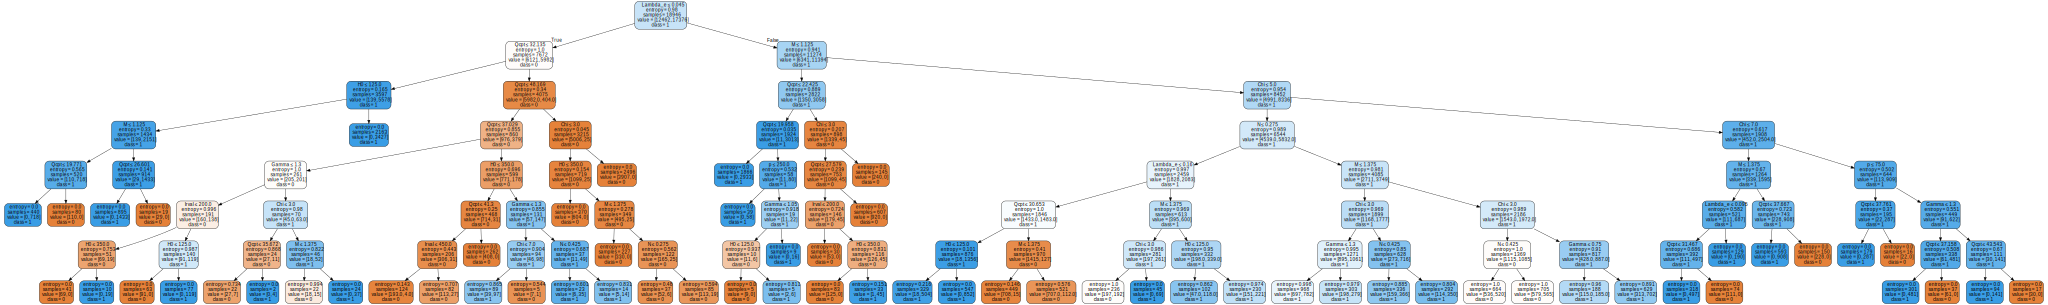

In [11]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

# Assuming 'best_rf_model' is your trained Random Forest model
tree = best_rf_model.estimators_[0]  # Select the first tree in the forest

dot_data = export_graphviz(tree,
                            out_file=None,
                            feature_names=X_train.columns,  # Use feature names from your data
                            class_names=['0', '1'],  # Use class names if applicable
                            filled=True,
                            rounded=True,
                            special_characters=True)

graph = graphviz.Source(dot_data)
display(graph)


## Summary:

### 1. Q&A

* **What is the relationship between 'Qcpt' and 'state'?** 'Qcpt' shows a strong negative correlation (-0.70) with 'state'.
* **What is the relationship between 'Lambda_e' and 'state'?** 'Lambda_e' has a moderate positive correlation (0.14) with 'state'.
* **How did the model perform on the test set?** The model performed exceptionally well, achieving near-perfect performance with high precision, recall, F1-score, and accuracy (all close to or at 1.00). The AUC is extremely high (0.9999).
* **What are the best hyperparameters found by GridSearchCV?** The best hyperparameters are `n_estimators`, `max_depth`, `min_samples_split`, and `criterion`. You can obtain the specific values from the output of the GridSearchCV in your notebook.


### 2. Data Analysis Key Findings

* **Strong Correlation:** 'Qcpt' exhibits a strong negative correlation (-0.70) with the soil state, while 'Lambda_e' shows a moderate positive correlation (0.14).
* **Class Imbalance (after preprocessing):** After removing the "gray zone" (state = 0) and creating the binary target variable, there are 24910 instances of the contracting soil class (binary_state = 1) and 17718 instances of the dilative soil class (binary_state = 0).
* **High Model Accuracy:** The optimized Random Forest model achieved near-perfect performance on the test set, with accuracy, precision, recall, and F1-score all close to 1.00.
* **Excellent Discrimination:** The AUC score of 0.9999 suggests the model has excellent discriminatory power between contracting and dilative soil behavior.


### 3. Insights or Next Steps

* **Feature Importance:** Investigate the importance of each feature in the model's prediction. Random Forests provide feature importance scores, which can help in understanding the model's decision-making process. Features with low importance could be removed, potentially simplifying the model and improving performance (especially if there are many features).
* **Robustness Evaluation:** Evaluate the model's performance on a more diverse dataset. The current analysis might be limited by the characteristics of the available data and does not fully capture all real-world scenarios.
* **Hyperparameter Tuning:** Further fine-tuning of hyperparameters, such as `n_estimators`, `max_depth`, and `min_samples_split`, could potentially lead to even better performance.
* **Ensemble Methods:** Explore other ensemble methods, such as Gradient Boosting or AdaBoost, to see if they can further improve the model's performance.